# The purpose of this code is to recover Chapter 1's plots and examples

In [1]:
#Import libraries

#Data Manipulation
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Stats
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import PowerTransformer

#Others
import warnings 

sns.set_style('white')
warnings.simplefilter('ignore')
%matplotlib inline

# Chapter 1.1

In [2]:
#Read in Data

'''Data was pulled from R package'''

df_in = pd.read_csv('./datasets/segmentationData.csv',index_col = 0)

In [3]:
df_in.head()

,PredictorA,PredictorB,Class,Case
1,742.115646,68.783380,PS,Test
2,3278.725624,154.898761,PS,Train
3,1727.410431,84.564598,WS,Train
4,1194.931973,101.091070,PS,Train
5,1140.426304,86.466698,PS,Test


## 1. Figure 1.2(a)

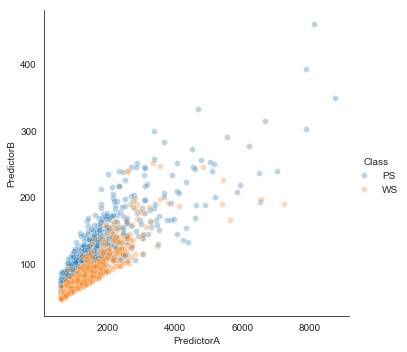

In [4]:
_ = sns.pairplot(x_vars=['PredictorA'],y_vars = ['PredictorB'], data= df_in, hue = 'Class',size = 5,plot_kws = dict(alpha = .3))

## 2. Apply Logistic Regression Model to Estimate Model Parameters & Plot ROC Curve

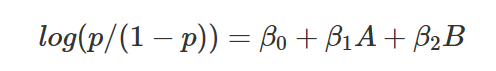

### use MLE to estimate

In [5]:
#Split the data into training and test

df_train = df_in[df_in['Case'] == 'Train']
df_test = df_in[df_in['Case'] == 'Test']

print('The length of the training dataset is: ', len(df_train))

print('The length of the test dataset is: ', len(df_test))

The length of the training dataset is:  1009
The length of the test dataset is:  1010


In [6]:
X_train = df_train[['PredictorA','PredictorB']]
X_train = sm.add_constant(X_train)

#Create a 0/1 column
df_train['Class2'] = np.where(df_train['Class'] == 'PS',0,1)
y_train = df_train[['Class2']]

logit = sm.Logit(y_train,X_train)
results = logit.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.561517
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Class2   No. Observations:                 1009
Model:                          Logit   Df Residuals:                     1006
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Apr 2020   Pseudo R-squ.:                  0.1476
Time:                        13:19:21   Log-Likelihood:                -566.57
converged:                       True   LL-Null:                       -664.71
                                        LLR p-value:                 2.389e-43
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7312      0.253      6.853      0.000       1.236       2.226
PredictorA     0.0026      0.000     10.131      0.000       0.002       0.003
PredictorB    -0.0644      0.006    -10.827      0.000      -0.076      -0.053
==============================================================================
"""

In [7]:
results.params

const         1.731243
PredictorA    0.002622
PredictorB   -0.064411
dtype: float64

In [9]:
#Predict using test data

X_test = df_test[['PredictorA','PredictorB']]
y_test = np.where(df_test['Class'] == 'PS',0,1)

y_pred = results.predict(sm.add_constant(X_test))

len(y_pred)

1010

In [10]:
#Calculate fpr,tpr,and threshold
fpr,tpr,threshold = roc_curve(y_test,y_pred)

AUC Score is:  0.7939489170555054


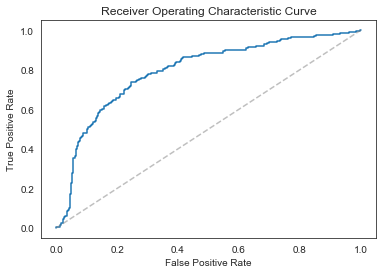

In [11]:
plt.title('Receiver Operating Characteristic Curve')
_ = plt.plot(fpr,tpr)
_ = plt.plot([0,1],ls ='--',color = 'gray',alpha = .5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('AUC Score is: ', roc_auc_score(y_test,y_pred))

## 3. Improve AUC Score

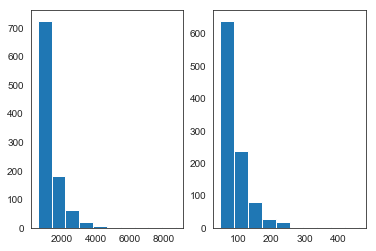

In [13]:
#1. Check distributions of independent variables
fig,(ax1,ax2) = plt.subplots(1,2)
_ = ax1.hist(df_train['PredictorA'])
_ = ax2.hist(df_train['PredictorB'])

### Note: From above distribution it can be seen that both vairables are skewed to the right, and it might be better to transform these predictors to a scale that could have normal distribution

In [14]:
#Transform data: using Box_Cox on inverse data
def transformation(df,varlist):
    pt = PowerTransformer(method = 'box-cox')
    for i in varlist:
        df[f'{i}_T'] = pd.Series(pt.fit_transform(df[i].values.reshape(-1,1)).reshape(-1))
    return df

In [15]:
#Based on this transformation results, it seems that does not work, and put the both varaibes on the inverse scale works for
#transforming data on the Gussian-like scale

X_trainT = transformation(df_train,['PredictorA','PredictorB'])
X_testT = transformation(df_test,['PredictorA','PredictorB'])

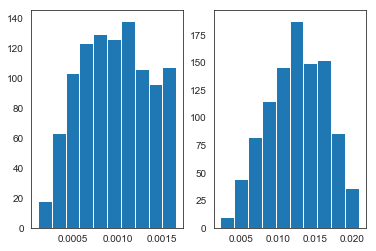

In [39]:
fig,(ax1,ax2) = plt.subplots(1,2)
_ =ax1.hist(1/X_train['PredictorA'])
_ = ax2.hist(1/X_train['PredictorB'])

(0.0, 0.0025)

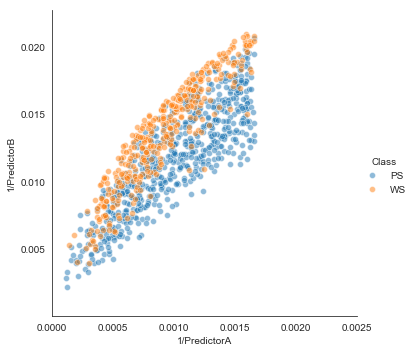

In [26]:
#Scatter plot
df_train['Inv_PA'] = 1/df_train['PredictorA']
df_train['Inv_PB'] = 1/df_train['PredictorB']
df_test['Inv_PA'] = 1/df_test['PredictorA']
df_test['Inv_PB'] = 1/df_test['PredictorB']

_ = sns.pairplot(x_vars = ['Inv_PA'],y_vars =['Inv_PB'],data = df_train, hue = 'Class',size = 5, plot_kws = dict(alpha = .5))
plt.xlabel('1/PredictorA')
plt.ylabel('1/PredictorB')
plt.xlim([0.0000,0.0025])


In [29]:
#Fit the transformed data
X_trainInv,X_testInv = df_train[['Inv_PA','Inv_PB']], df_test[['Inv_PA','Inv_PB']]

Results2 = sm.Logit(y_train,sm.add_constant(X_trainInv)).fit()

Optimization terminated successfully.
         Current function value: 0.464784
         Iterations 11


In [31]:
Results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Class2   No. Observations:                 1009
Model:                          Logit   Df Residuals:                     1006
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Apr 2020   Pseudo R-squ.:                  0.2945
Time:                        16:30:55   Log-Likelihood:                -468.97
converged:                       True   LL-Null:                       -664.71
                                        LLR p-value:                 9.771e-86
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0753      0.292    -10.521      0.000      -3.648      -2.502
Inv_PA     -8083.6761    568.590    -14.217      0.000   -9198.093   -6969.259
Inv_PB       799.6924     53.250     15.018      0.000     695.325     904.060
==============================================================================
"""

Before data transformation, the AUC Score is:  0.7939489170555054
After data transformation, the AUC Score is:  0.8492844209206769


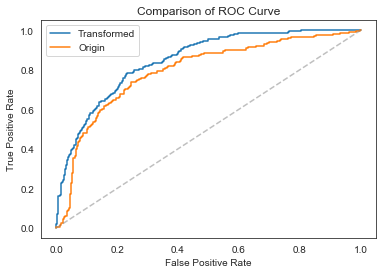

In [38]:
y_predT = Results2.predict(sm.add_constant(X_testInv))
fprT,tprT,thresholdT = roc_curve(y_test,y_predT)
_ = plt.plot(fprT,tprT,label = 'Transformed')
_ = plt.plot(fpr,tpr,label = 'Origin')
_ = plt.plot([0,1],ls = '--',color = 'gray',alpha = .5)
plt.legend(loc = 'best')
plt.title('Comparison of ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

print('Before data transformation, the AUC Score is: ', roc_auc_score(y_test,y_pred))
print('After data transformation, the AUC Score is: ',roc_auc_score(y_test,y_predT))

# Chapter 1.2